# Part 3: An Unsupervised Model / Clustering

### Import Libraries

In [36]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

### Import the dataset

In [10]:
with open('data/samples_imputed.pkl', 'rb') as f:
    samples_imputed = pickle.load(f)

### Make a dataset of the 2% highest variance columns:

In [11]:
samples_imputed = samples_imputed.transpose()
samples_imputed.head()

#create a variance column:
samples_imputed['var'] = samples_imputed.var(axis = 1)

In [4]:
# # slicing the is_target row; append it later as the target column

# is_cancer = samples_imputed.loc['is_cancer',:]

In [12]:
# sort the table by the variance values os DNA sites
samples_imputed.sort_values(by=['var'], ascending=False).head()

,0,1,2,3,4,5,6,7,8,9,...,725,726,727,728,729,730,731,732,733,var
cg16620382,0.02,0.08,0.36,0.55,0.80,0.14,0.93,0.60,0.00,0.80,...,0.02,0.01,0.00,0.08,0.12,0.04,0.000,0.03,0.05,0.121854
cg11738485,0.01,0.00,0.80,0.65,0.87,0.99,0.03,0.61,0.91,0.98,...,0.60,0.60,0.59,0.03,0.01,0.61,0.590,0.57,0.02,0.119038
cg27363327,0.05,0.15,0.17,0.35,0.73,0.11,0.89,0.63,0.15,0.78,...,0.05,0.05,0.01,0.09,0.08,0.05,0.000,0.03,0.08,0.118166
cg11574174,0.12,0.86,0.59,0.00,0.84,0.20,0.00,0.83,0.16,0.78,...,0.86,0.74,0.77,0.65,0.80,0.00,0.730,0.05,0.33,0.117441
cg18391209,0.85,0.23,0.73,0.02,0.09,0.11,0.87,0.09,0.00,0.84,...,0.09,0.86,0.27,0.14,0.85,0.12,0.556,0.80,0.80,0.115076


In [42]:
highest_variace_samples = samples_imputed.sort_values(by=['var'], ascending=False).head(9000).T

# Drop the variance row:
highest_variace_samples.drop(highest_variace_samples.tail(1).index, inplace=True)

# check shape
highest_variace_samples.shape

(734, 9000)

In [43]:
# check target column
highest_variace_samples['is_cancer']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
729    0.0
730    0.0
731    0.0
732    0.0
733    0.0
Name: is_cancer, Length: 734, dtype: float32

In [44]:
# pickle:
with open('data/highest_variace_samples.pkl', 'wb') as f:
    pickle.dump(highest_variace_samples, f)

**The dataframe (highest_variance_samples) includes 9,000 DNA sites with the highest variance in methylation patterns.**

### Set Up X and y

In [28]:
with open('data/highest_variace_samples.pkl', 'rb') as f:
    highest_variace_samples = pickle.load(f)

In [45]:
X = highest_variace_samples.drop(columns=['is_cancer'])
y = highest_variace_samples['is_cancer']

# Scale
X_sc = StandardScaler().fit_transform(X)
X_sc

array([[-1.2288383 , -1.475894  , -1.0805773 , ..., -1.4446567 ,
        -0.5609188 , -0.9151127 ],
       [-1.0568384 , -1.5048976 , -0.7894725 , ...,  0.08855465,
         1.964383  , -0.77982527],
       [-0.25417233,  0.8153996 , -0.73125166, ..., -0.09182313,
         0.07040671, -0.7347295 ],
       ...,
       [-1.2861716 ,  0.20632145, -1.2261295 , ...,  0.22383815,
         1.7389096 , -0.8249211 ],
       [-1.2001716 ,  0.14831406, -1.1387981 , ...,  0.8551605 ,
         2.099667  , -0.77982527],
       [-1.1428384 , -1.4468902 , -0.99324584, ...,  0.719877  ,
        -0.651108  , -0.7347295 ]], dtype=float32)

### 1. KNN
Clustering the samples with kmeans

In [13]:
# instantiate the model with the default settings:
kmeans = KMeans()
kmeans.fit(X_sc)

# see how many clusters there are:
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7}

In [61]:
# Try other k values:
kmeans_sil = []

for k in range(2,15):
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(X_sc)
    kmeans_sil.append(silhouette_score(X_sc, kmeans.labels_))


#### An elbow plot of the silouette score:

<AxesSubplot:>

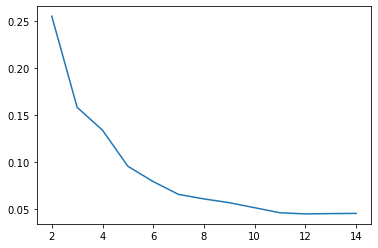

In [62]:
sns.lineplot(x=range(2,15), y=kmeans_sil)

As seen at the plot, the optimal number of clusters (k) is **2**.

In [87]:
# make a new df with the kmeans labels column:

# instantiate a new kmean model with k = 2
kmeans2 = KMeans(n_clusters=2)
kmeans2.fit(X_sc)

# copying the original df
highest_var_kmeans = X.copy()

# add labels column
highest_var_kmeans['kmeans_labels'] = kmeans2.labels_
highest_var_kmeans.head(3)

,cg16620382,cg11738485,cg27363327,cg11574174,cg18391209,cg27260772,cg01893212,cg27493151,cg17882374,cg11426075,...,cg12193833,cg01024175,cg24440302,cg04569429,cg03032214,cg06048354,cg14511923,cg01806382,cg13557668,kmeans_labels
0,0.02,0.01,0.05,0.12,0.85,0.71,0.03,0.10,0.16,0.360,...,0.53,0.32,0.04,0.25,0.09,0.19,0.17,0.32,0.02,1
1,0.08,0.00,0.15,0.86,0.23,0.60,0.71,0.88,0.98,0.310,...,0.45,0.73,0.51,0.72,0.34,0.76,0.51,0.88,0.05,0
2,0.36,0.80,0.17,0.59,0.73,0.88,0.04,0.87,0.98,0.298,...,0.77,0.59,0.48,0.42,0.12,0.64,0.47,0.46,0.06,1


In [88]:
highest_var_kmeans['kmeans_labels'].value_counts()

0    403
1    332
Name: kmeans_labels, dtype: int64

- As the dataset is imbalanced, I expected the clustering model output to be the same (approximately 1:6.7). KNN did not cluster as expected. 

## 2. tSNE

In [46]:
# Apply tSNE model
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X)
X_embedded.shape

(734, 2)

C:\Users\Marva\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


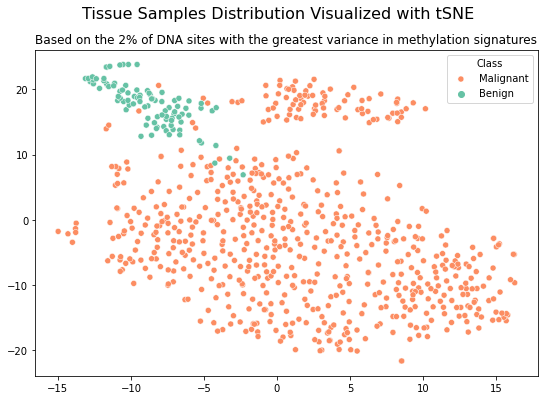

In [91]:
plt.figure(figsize=(9,6))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, palette='Set2')
plt.title('Based on the 2% of DNA sites with the greatest variance in methylation signatures')
plt.suptitle('Tissue Samples Distribution Visualized with tSNE', fontsize = 16)
plt.legend(title='Class', loc='upper right', labels=['Malignant', 'Benign'])
plt.savefig("images/tSNE.png") 